# 设置环境

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader

# 准备数据集
导入就绪后，我们可以继续准备将要使用的数据。但在那之前，我们将定义超参数，我们将使用的实验。在这里，epoch的数量定义了我们将循环整个训练数据集的次数，而learning_rate和momentum是我们稍后将使用的优化器的超参数。

In [3]:
n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([4, 4, 2, 1, 8, 8, 2, 8, 3, 8, 5, 5, 5, 3, 0, 3, 6, 3, 0, 7, 0, 7, 2, 3,
        3, 4, 8, 2, 6, 1, 1, 2, 9, 5, 8, 2, 0, 3, 2, 3, 9, 9, 9, 3, 7, 9, 5, 7,
        2, 1, 6, 7, 2, 9, 3, 1, 3, 2, 0, 4, 8, 7, 5, 2, 4, 6, 5, 3, 9, 8, 9, 6,
        2, 8, 3, 9, 5, 9, 5, 0, 0, 4, 0, 2, 3, 0, 2, 8, 5, 8, 2, 2, 1, 3, 1, 5,
        1, 7, 2, 8, 8, 4, 2, 2, 9, 3, 1, 1, 4, 7, 2, 8, 7, 6, 2, 7, 6, 3, 6, 1,
        9, 0, 9, 7, 7, 9, 4, 0, 9, 4, 0, 2, 0, 7, 5, 9, 0, 4, 6, 7, 9, 4, 2, 4,
        0, 1, 2, 1, 4, 9, 3, 5, 3, 7, 8, 8, 3, 8, 5, 9, 1, 8, 3, 6, 8, 3, 3, 8,
        1, 6, 7, 4, 3, 3, 5, 6, 9, 6, 0, 2, 5, 1, 8, 0, 1, 4, 1, 1, 1, 7, 2, 7,
        1, 1, 0, 4, 7, 2, 4, 6, 1, 4, 3, 6, 2, 7, 5, 4, 1, 3, 3, 3, 4, 7, 8, 0,
        4, 3, 5, 8, 9, 4, 1, 9, 4, 7, 7, 1, 9, 6, 0, 4, 2, 9, 2, 1, 3, 6, 6, 0,
        2, 2, 0, 0, 2, 5, 8, 9, 7, 0, 0, 9, 2, 0, 9, 2, 6, 9, 9, 5, 4, 3, 2, 9,
        9, 4, 3, 5, 1, 3, 8, 5, 8, 4, 9, 5, 1, 4, 4, 6, 0, 7, 6, 8, 8, 8, 0, 9,
        8, 4, 5, 9, 4, 6, 3, 9, 9, 4, 5,

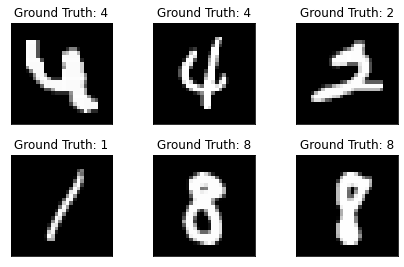

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# 构建网络
现在让我们开始建立我们的网络。我们将使用两个2d卷积层，然后是两个全连接(或线性)层。作为激活函数，我们将选择整流线性单元(简称ReLUs)，作为正则化的手段，我们将使用两个dropout层。在PyTorch中，构建网络的一个好方法是为我们希望构建的网络创建一个新类。让我们在这里导入一些子模块，以获得更具可读性的代码。

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def log_softmax(x):
    x = torch.exp(x)
    x = x / torch.sum(x,dim=1).unsqueeze(1)
    x = torch.log(x)
    return x
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return log_softmax(x)
    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        self.bn3 = nn.BatchNorm1d(320)
        self.bn4 = nn.BatchNorm1d(50)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn2(x)
        x = x.view(-1, 320)
        x = self.bn3(x)
        x = F.relu(self.fc1(x))
        x = self.bn4(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return log_softmax(x)

初始化网络和优化器

In [8]:
network1 = Net1()
network2 = Net2()
optimizer1 = optim.SGD(network1.parameters(), lr=learning_rate,
                      momentum=momentum)
optimizer2 = optim.SGD(network2.parameters(), lr=learning_rate,
                      momentum=momentum)

# 模型训练
首先，我们需要使用optimizer.zero_grad()手动将梯度设置为零，因为PyTorch在默认情况下会累积梯度。然后，我们生成网络的输出(前向传递)，并计算输出与真值标签之间的负对数概率损失。现在，我们收集一组新的梯度，并使用optimizer.step()将其传播回每个网络参数。有关PyTorch自动渐变系统内部工作方式的详细信息，请参阅autograd的官方文档(强烈推荐)。

我们还将使用一些打印输出来跟踪进度。为了在以后创建一个良好的培训曲线，我们还创建了两个列表来节省培训和测试损失。在x轴上，我们希望显示网络在培训期间看到的培训示例的数量。

In [9]:
def train(epoch,net,opt):
  counter = []
  train_losses = []
  test_losses = []
  train_accs = []
  test_accs = []
  net.train() #训练模式
  for batch_idx, (data, target) in enumerate(train_loader):
    opt.zero_grad()
    output = net(data)
    loss = F.nll_loss(output, target)  #有log_softmax层
    loss.backward()
    opt.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      test_loss, test_acc = test(net)
      test_losses.append(test_loss)
      test_accs.append(test_acc)
      torch.save(net.state_dict(), './model.pth')
      torch.save(opt.state_dict(), './optimizer.pth')
  return counter, train_losses, test_losses, train_accs, test_accs       
# train(1)

# 模型测试
现在进入测试循环。在这里，我们总结了测试损失，并跟踪正确分类的数字来计算网络的精度。

In [10]:
def test(net):
  net.eval() #测试模式
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = net(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  test_acc = correct / len(test_loader.dataset)
  return test_loss, test_acc
test(network1)
test(network2)

D:\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)


Test set: Avg. loss: 2.3125, Accuracy: 1079/10000 (11%)



(2.312547021484375, tensor(0.1079))

# 评估模型的性能

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340686

Test set: Avg. loss: 2.2860, Accuracy: 1376/10000 (14%)

Train Epoch: 1 [640/60000 (1%)]	Loss: 1.731482

Test set: Avg. loss: 2.2034, Accuracy: 1969/10000 (20%)

Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.567229

Test set: Avg. loss: 1.3367, Accuracy: 6349/10000 (63%)

Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.561973

Test set: Avg. loss: 0.5750, Accuracy: 8260/10000 (83%)

Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.708482

Test set: Avg. loss: 0.5413, Accuracy: 8225/10000 (82%)

Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.396389

Test set: Avg. loss: 0.3549, Accuracy: 8788/10000 (88%)

Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.271233

Test set: Avg. loss: 0.3799, Accuracy: 8671/10000 (87%)

Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.272861

Test set: Avg. loss: 0.3136, Accuracy: 8959/10000 (90%)

Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.194051

Test set: Avg. loss: 0.1946, Accuracy: 9380/10000 (94%)

Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.234014




Test set: Avg. loss: 0.0602, Accuracy: 9821/10000 (98%)

Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.047418

Test set: Avg. loss: 0.0557, Accuracy: 9825/10000 (98%)

Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.095748

Test set: Avg. loss: 0.0717, Accuracy: 9764/10000 (98%)

Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.099374

Test set: Avg. loss: 0.0546, Accuracy: 9835/10000 (98%)

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.010040

Test set: Avg. loss: 0.0601, Accuracy: 9808/10000 (98%)

Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.134590

Test set: Avg. loss: 0.0489, Accuracy: 9857/10000 (99%)

Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.022814

Test set: Avg. loss: 0.0574, Accuracy: 9831/10000 (98%)

Train Epoch: 1 [53120/60000 (88%)]	Loss: 0.043073

Test set: Avg. loss: 0.0506, Accuracy: 9844/10000 (98%)

Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.066193

Test set: Avg. loss: 0.0763, Accuracy: 9759/10000 (98%)

Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.043903

Test set: Avg. loss: 0.0668

Train Epoch: 1 [37760/60000 (63%)]	Loss: 0.046451

Test set: Avg. loss: 0.0542, Accuracy: 9821/10000 (98%)

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.038806

Test set: Avg. loss: 0.0623, Accuracy: 9802/10000 (98%)

Train Epoch: 1 [39040/60000 (65%)]	Loss: 0.027548

Test set: Avg. loss: 0.0540, Accuracy: 9825/10000 (98%)

Train Epoch: 1 [39680/60000 (66%)]	Loss: 0.145275

Test set: Avg. loss: 0.0583, Accuracy: 9810/10000 (98%)

Train Epoch: 1 [40320/60000 (67%)]	Loss: 0.096567

Test set: Avg. loss: 0.0562, Accuracy: 9819/10000 (98%)

Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.021684

Test set: Avg. loss: 0.0508, Accuracy: 9838/10000 (98%)

Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.048532

Test set: Avg. loss: 0.0533, Accuracy: 9823/10000 (98%)

Train Epoch: 1 [42240/60000 (70%)]	Loss: 0.036940

Test set: Avg. loss: 0.0522, Accuracy: 9821/10000 (98%)

Train Epoch: 1 [42880/60000 (71%)]	Loss: 0.073932

Test set: Avg. loss: 0.0720, Accuracy: 9764/10000 (98%)

Train Epoch: 1 [43520/60000 

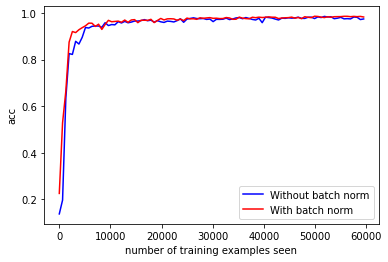

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316403

Test set: Avg. loss: 2.3178, Accuracy: 878/10000 (9%)

Train Epoch: 1 [640/60000 (1%)]	Loss: 2.307414

Test set: Avg. loss: 2.2944, Accuracy: 1085/10000 (11%)

Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.278974

Test set: Avg. loss: 2.2717, Accuracy: 1073/10000 (11%)

Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.259606

Test set: Avg. loss: 2.2468, Accuracy: 1380/10000 (14%)

Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.238592

Test set: Avg. loss: 2.2152, Accuracy: 1996/10000 (20%)

Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.154538

Test set: Avg. loss: 2.1649, Accuracy: 2322/10000 (23%)

Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.085397

Test set: Avg. loss: 2.0905, Accuracy: 4643/10000 (46%)

Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.984469

Test set: Avg. loss: 1.9706, Accuracy: 6093/10000 (61%)

Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.716300

Test set: Avg. loss: 1.7703, Accuracy: 5776/10000 (58%)

Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.507020

Te


Test set: Avg. loss: 0.1648, Accuracy: 9501/10000 (95%)

Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.157717

Test set: Avg. loss: 0.1489, Accuracy: 9566/10000 (96%)

Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.216153

Test set: Avg. loss: 0.1499, Accuracy: 9567/10000 (96%)

Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.218481

Test set: Avg. loss: 0.1421, Accuracy: 9593/10000 (96%)

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.156107

Test set: Avg. loss: 0.1438, Accuracy: 9590/10000 (96%)

Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.256839

Test set: Avg. loss: 0.1558, Accuracy: 9544/10000 (95%)

Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.233785

Test set: Avg. loss: 0.1377, Accuracy: 9603/10000 (96%)

Train Epoch: 1 [53120/60000 (88%)]	Loss: 0.161407

Test set: Avg. loss: 0.1350, Accuracy: 9632/10000 (96%)

Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.088012

Test set: Avg. loss: 0.1565, Accuracy: 9546/10000 (95%)

Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.078623

Test set: Avg. loss: 0.1365

Train Epoch: 1 [37760/60000 (63%)]	Loss: 0.102294

Test set: Avg. loss: 0.1416, Accuracy: 9551/10000 (96%)

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.113956

Test set: Avg. loss: 0.1429, Accuracy: 9572/10000 (96%)

Train Epoch: 1 [39040/60000 (65%)]	Loss: 0.024896

Test set: Avg. loss: 0.1247, Accuracy: 9630/10000 (96%)

Train Epoch: 1 [39680/60000 (66%)]	Loss: 0.136367

Test set: Avg. loss: 0.1453, Accuracy: 9528/10000 (95%)

Train Epoch: 1 [40320/60000 (67%)]	Loss: 0.111851

Test set: Avg. loss: 0.1251, Accuracy: 9621/10000 (96%)

Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.161661

Test set: Avg. loss: 0.1296, Accuracy: 9571/10000 (96%)

Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.151580

Test set: Avg. loss: 0.1167, Accuracy: 9633/10000 (96%)

Train Epoch: 1 [42240/60000 (70%)]	Loss: 0.140660

Test set: Avg. loss: 0.1227, Accuracy: 9636/10000 (96%)

Train Epoch: 1 [42880/60000 (71%)]	Loss: 0.086205

Test set: Avg. loss: 0.1235, Accuracy: 9639/10000 (96%)

Train Epoch: 1 [43520/60000 

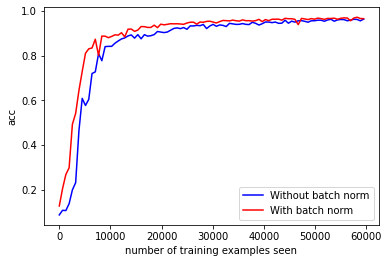

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327745

Test set: Avg. loss: 2.3182, Accuracy: 981/10000 (10%)

Train Epoch: 1 [640/60000 (1%)]	Loss: 2.344867

Test set: Avg. loss: 2.3146, Accuracy: 983/10000 (10%)

Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.311078

Test set: Avg. loss: 2.3112, Accuracy: 982/10000 (10%)

Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.300212

Test set: Avg. loss: 2.3078, Accuracy: 981/10000 (10%)

Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.303140

Test set: Avg. loss: 2.3044, Accuracy: 987/10000 (10%)

Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.311700

Test set: Avg. loss: 2.3013, Accuracy: 990/10000 (10%)

Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.308230

Test set: Avg. loss: 2.2983, Accuracy: 1003/10000 (10%)

Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.299636

Test set: Avg. loss: 2.2955, Accuracy: 1006/10000 (10%)

Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.278811

Test set: Avg. loss: 2.2926, Accuracy: 1012/10000 (10%)

Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.311478

Test s


Test set: Avg. loss: 1.3715, Accuracy: 7234/10000 (72%)

Train Epoch: 1 [49280/60000 (82%)]	Loss: 1.469589

Test set: Avg. loss: 1.3336, Accuracy: 7467/10000 (75%)

Train Epoch: 1 [49920/60000 (83%)]	Loss: 1.307328

Test set: Avg. loss: 1.2957, Accuracy: 7440/10000 (74%)

Train Epoch: 1 [50560/60000 (84%)]	Loss: 1.292806

Test set: Avg. loss: 1.2570, Accuracy: 7528/10000 (75%)

Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.199210

Test set: Avg. loss: 1.2150, Accuracy: 7536/10000 (75%)

Train Epoch: 1 [51840/60000 (86%)]	Loss: 1.219238

Test set: Avg. loss: 1.1772, Accuracy: 7461/10000 (75%)

Train Epoch: 1 [52480/60000 (87%)]	Loss: 1.272451

Test set: Avg. loss: 1.1403, Accuracy: 7516/10000 (75%)

Train Epoch: 1 [53120/60000 (88%)]	Loss: 1.179651

Test set: Avg. loss: 1.1080, Accuracy: 7589/10000 (76%)

Train Epoch: 1 [53760/60000 (90%)]	Loss: 1.243271

Test set: Avg. loss: 1.0747, Accuracy: 7742/10000 (77%)

Train Epoch: 1 [54400/60000 (91%)]	Loss: 1.113561

Test set: Avg. loss: 1.0401

Train Epoch: 1 [37760/60000 (63%)]	Loss: 2.109783

Test set: Avg. loss: 2.1025, Accuracy: 4524/10000 (45%)

Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.076771

Test set: Avg. loss: 2.0923, Accuracy: 4618/10000 (46%)

Train Epoch: 1 [39040/60000 (65%)]	Loss: 2.117188

Test set: Avg. loss: 2.0818, Accuracy: 4651/10000 (47%)

Train Epoch: 1 [39680/60000 (66%)]	Loss: 2.032691

Test set: Avg. loss: 2.0699, Accuracy: 4818/10000 (48%)

Train Epoch: 1 [40320/60000 (67%)]	Loss: 2.071779

Test set: Avg. loss: 2.0572, Accuracy: 5023/10000 (50%)

Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.019470

Test set: Avg. loss: 2.0433, Accuracy: 5045/10000 (50%)

Train Epoch: 1 [41600/60000 (69%)]	Loss: 2.083713

Test set: Avg. loss: 2.0294, Accuracy: 4947/10000 (49%)

Train Epoch: 1 [42240/60000 (70%)]	Loss: 1.939781

Test set: Avg. loss: 2.0137, Accuracy: 5027/10000 (50%)

Train Epoch: 1 [42880/60000 (71%)]	Loss: 1.991029

Test set: Avg. loss: 1.9958, Accuracy: 5180/10000 (52%)

Train Epoch: 1 [43520/60000 

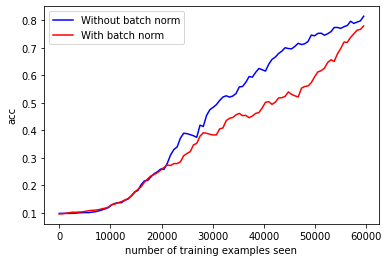

In [11]:
# test()
lrs = [0.1,0.01,0.001]
for lr in lrs:
    counter1 = []
    train_losses1 = []
    test_losses1 = []
    train_accs1 = []
    test_accs1 = []
    counter2 = []
    train_losses2 = []
    test_losses2 = []
    train_accs2 = []
    test_accs2 = []
    network1 = Net1()
    network2 = Net2()
    optimizer1 = optim.SGD(network1.parameters(), lr=lr,
                          momentum=momentum)
    optimizer2 = optim.SGD(network2.parameters(), lr=lr,
                          momentum=momentum)
    for epoch in range(1, n_epochs + 1):
      counter1, train_losses1, test_losses1, train_accs1, test_accs1 = train(epoch,network1,optimizer1)
      counter2, train_losses2, test_losses2, train_accs2, test_accs2 = train(epoch,network2,optimizer2)
    # fig = plt.figure()
    # plt.plot(train_counter, train_losses, color='blue')
    # plt.scatter(train_counter, test_losses, color='red')
    # plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    # plt.xlabel('number of training examples seen')
    # plt.ylabel('negative log likelihood loss')
    # plt.show()
    fig = plt.figure()
    plt.plot(counter1, test_accs1, color='blue',label='Without batch norm')
    plt.plot(counter2, test_accs2, color='red',label='With batch norm')
    plt.legend()
    plt.xlabel('number of training examples seen')
    plt.ylabel('acc')
    plt.show()